<a href="https://colab.research.google.com/github/gabriel-u-freitas/Simulacao_de_Monte_Carlo_com_VaR_e_ES/blob/main/Simula%C3%A7%C3%A3o_de_Monte_Carlo_com_VaR_e_ES_Sprint_18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Monte Carlo**

In [ ]:
#Importar bibliotecas
import pandas as pd
import pandas_datareader as data
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sy
import random
from math import exp

In [ ]:
#Escolher ativo para simulação
ativo = ['PRIO3.SA']

#Buscar e fazer download do histórico de preço ajustado
preco = data.DataReader(ativo, data_source='yahoo', start='2020-12-17', end='2021-12-17')
preco_ajustado = preco['Adj Close']
preco_ajustado = preco_ajustado.reset_index()
preco_ajustado = preco_ajustado.set_index('Date')

In [ ]:
#Calcular log retornos
preco_ajustado['Log Retorno'] = np.log(preco_ajustado / preco_ajustado.shift(1))

In [ ]:
#Calcular média dos log retornos dos últimos 200 dias
média = np.mean(preco_ajustado.iloc[-200:,1])

#Calcular volatilidade do ativo dos últimos 200 dias
desv_pad = np.std(preco_ajustado.iloc[-200:,1])

#Calcular drift/deriva (u-variância/2) com base nos últimos 200 dias
drift = média - desv_pad**2*0.5
print(média)
print(desv_pad)
print(drift)
print(preco_ajustado)

0.000877249887562704
0.033761375147361695
0.00030733466164225805
Symbols      PRIO3.SA  Log Retorno
Date                              
2020-12-17  11.650000          NaN
2020-12-18  11.350000    -0.026088
2020-12-21  11.320000    -0.002647
2020-12-22  11.936000     0.052988
2020-12-23  13.226000     0.102626
...               ...          ...
2021-12-13  20.389999    -0.015089
2021-12-14  19.700001    -0.034426
2021-12-15  19.900000     0.010101
2021-12-16  20.020000     0.006012
2021-12-17  20.420000     0.019783

[247 rows x 2 columns]


In [ ]:
#Criar função que simula a evolução do preço do ativo para 30 dias e armazena essa evoluação na lista 'price'
def simulação_diária():
    price = [preco_ajustado.iloc[-1, 0]] #o primeiro dia da lista 'price' é o último dia do dataset histórico do preço ajustado
    for i in range(1, 31):
        price.append(price[i-1] * exp(drift + desv_pad * sy.norm.ppf(random.uniform(0,1))))
    return(price)

In [ ]:
#Criar uma lista de listas com todas as 1000 simulações (lista 'simulação' armazena 1000 listas 'price')
simulação = []
for i in range(1000):
    simulação.append(simulação_diária())

In [ ]:
#Todas as X simulações são armazendas em um df
monte_carlo = pd.DataFrame(data=simulação)

In [ ]:
#Visualização do df criado
monte_carlo

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,20.42,21.523131,20.232930,20.129448,19.796626,20.825687,20.712185,21.691584,21.306318,20.610956,21.410536,21.534140,21.104679,20.794718,19.955904,19.116472,19.454847,18.657022,19.884792,20.143889,19.577585,20.064795,20.162872,20.067552,19.058179,19.259176,19.682498,19.364219,18.711327,18.676602,18.750027
1,20.42,20.458032,19.987911,18.827247,18.399237,18.806882,19.353153,18.810484,18.892347,19.070213,19.052063,18.660839,17.712977,17.984750,17.729793,17.501300,17.555114,16.468599,16.101962,16.170311,15.418213,16.137685,15.691907,15.815933,15.868267,15.097725,15.256961,15.131475,15.176884,15.439709,15.476797
2,20.42,18.861065,18.272400,18.012365,17.699745,18.393060,17.641839,17.352028,18.550730,17.574175,17.903382,18.155494,18.561457,18.340931,17.334138,17.452697,15.700643,16.083730,16.759655,17.081278,17.233997,17.654532,17.969056,18.909415,18.872910,19.536589,19.871470,20.630129,20.100489,19.717580,19.869451
3,20.42,19.977401,18.974243,18.175477,18.367520,18.452105,17.840685,17.435860,17.649006,16.830997,17.017948,16.892213,17.119903,17.646470,17.436249,17.908839,18.575906,18.386405,18.309216,18.259982,18.935590,18.745848,18.501173,19.708729,20.191921,20.289228,20.781080,21.114503,21.964501,21.196814,21.452109
4,20.42,19.637278,19.350535,19.503245,20.208470,21.198677,21.249488,20.268078,20.395012,20.529952,20.537732,19.632748,19.891319,19.241783,19.505774,19.299795,18.869561,19.312580,18.140859,17.337273,17.184531,18.185743,19.188177,18.207498,18.680358,18.221668,18.737335,18.377934,18.481999,17.246714,17.498560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,20.42,20.380695,20.110298,20.084429,20.586975,20.143260,19.828521,20.542768,20.368773,19.666608,19.845834,20.441140,19.800376,20.073373,18.716005,18.490499,18.360696,18.589694,19.127163,19.561078,20.254280,20.320226,19.690939,19.919850,20.862814,21.651834,21.711389,22.677082,22.887770,22.728105,22.067046
996,20.42,20.954915,21.311418,21.803070,21.483025,21.458546,20.536314,19.657908,19.183657,18.933387,19.629526,19.825712,18.683072,19.108632,18.012806,17.519274,16.779895,17.738640,18.666506,18.550054,18.461734,19.107372,18.918822,19.253700,19.020262,20.012362,18.573360,18.873466,19.506636,18.444790,17.842084
997,20.42,20.594538,20.193411,20.177127,21.495878,20.569382,20.086910,19.399996,20.274679,21.045135,21.094625,21.508678,21.361079,20.455342,21.395324,22.292872,22.312654,23.058413,21.751776,22.474216,22.600646,22.477440,24.196716,24.174693,24.408000,24.584430,26.599275,27.495235,27.323707,26.794594,28.191299
998,20.42,20.300388,19.735036,18.089203,18.561887,18.134436,18.304507,18.785113,18.937121,18.312187,18.578254,18.561704,19.289953,18.791795,19.306997,18.808936,18.507993,18.700084,17.569322,17.751273,17.389935,18.614285,17.654442,16.832960,16.442287,16.621474,17.664572,16.794211,16.443565,16.052398,16.558437


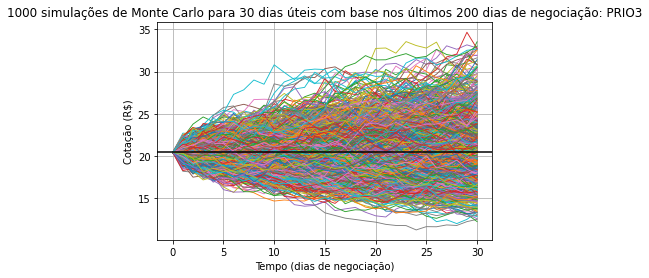

<Figure size 432x288 with 0 Axes>

In [ ]:
#Criar gráfico das X simulações geradas
#Transpor o df 'monte_carlo', pois o matplotlib plota - por padrão - colunas de dados e não linhas
fig,ax = plt.subplots()
ax.plot(monte_carlo.transpose(), linewidth = 0.90)

#Adicionar linhas horizontal no preço inicial (axhline)
plt.axhline(preco_ajustado.iloc[-1,0], color = 'black', linewidth = 1.5)

#Adicionar um título no gráfico (title)
plt.title('1000 simulações de Monte Carlo para 30 dias úteis com base nos últimos 200 dias de negociação: PRIO3')

#Adicionar descrições nos eixos coordenados (xlabel e ylabel)
plt.ylabel('Cotação (R$)')
plt.xlabel('Tempo (dias de negociação)')

#Adicionar uma grade para facilitar a leitura do gráfico (grid)
plt.grid()

#Mostar o gráfico
plt.show()

#Salvar imagem
plt.savefig('Monte_Carlo_PRIO3.png', dpi = 1000)

### **Value-at-Risk**

In [ ]:
#Criar um df que recebe os log retornos de cada simulação
monte_carlo_log = pd.DataFrame()
for i in range(1,31):
    monte_carlo_log['ln_{}'.format(i)] = np.log(monte_carlo[i] / monte_carlo[i-1])

In [ ]:
#Visualização do df criado
monte_carlo_log

,ln_1,ln_2,ln_3,ln_4,ln_5,ln_6,ln_7,ln_8,ln_9,ln_10,ln_11,ln_12,ln_13,ln_14,ln_15,ln_16,ln_17,ln_18,ln_19,ln_20,ln_21,ln_22,ln_23,ln_24,ln_25,ln_26,ln_27,ln_28,ln_29,ln_30
0,0.052613,-0.061817,-0.005128,-0.016672,0.050676,-0.005465,0.046202,-0.017921,-0.033181,0.038060,0.005756,-0.020145,-0.014796,-0.041174,-0.042975,0.017546,-0.041874,0.063733,0.012946,-0.028516,0.024581,0.004876,-0.004739,-0.051608,0.010491,0.021742,-0.016303,-0.034298,-0.001858,0.003924
1,0.001861,-0.023248,-0.059823,-0.022996,0.021914,0.028632,-0.028441,0.004343,0.009371,-0.000952,-0.020748,-0.052130,0.015227,-0.014278,-0.012971,0.003070,-0.063890,-0.022514,0.004236,-0.047627,0.045608,-0.028012,0.007873,0.003304,-0.049777,0.010492,-0.008259,0.002996,0.017169,0.002399
2,-0.079415,-0.031708,-0.014333,-0.017508,0.038423,-0.041700,-0.016564,0.066800,-0.054079,0.018559,0.013984,0.022114,-0.011952,-0.056457,0.006816,-0.105793,0.024107,0.041166,0.019009,0.008901,0.024109,0.017659,0.051009,-0.001932,0.034562,0.016996,0.037468,-0.026008,-0.019233,0.007673
3,-0.021913,-0.051519,-0.043009,0.010511,0.004595,-0.033697,-0.022952,0.012150,-0.047457,0.011046,-0.007416,0.013389,0.030294,-0.011984,0.026743,0.036571,-0.010254,-0.004207,-0.002693,0.036331,-0.010071,-0.013138,0.063227,0.024221,0.004808,0.023953,0.015917,0.039467,-0.035577,0.011972
4,-0.039085,-0.014710,0.007861,0.035521,0.047837,0.002394,-0.047286,0.006243,0.006595,0.000379,-0.045065,0.013084,-0.033199,0.013626,-0.010616,-0.022544,0.023207,-0.062590,-0.045308,-0.008849,0.056628,0.053656,-0.052461,0.025639,-0.024861,0.027907,-0.019367,0.005647,-0.069176,0.014497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.001927,-0.013356,-0.001287,0.024714,-0.021789,-0.015748,0.035388,-0.008506,-0.035081,0.009072,0.029555,-0.031849,0.013693,-0.070015,-0.012122,-0.007045,0.012395,0.028502,0.022432,0.034824,0.003251,-0.031458,0.011558,0.046252,0.037122,0.002747,0.043518,0.009248,-0.007000,-0.029517
996,0.025858,0.016870,0.022808,-0.014788,-0.001140,-0.043928,-0.043715,-0.024421,-0.013132,0.036108,0.009945,-0.059362,0.022522,-0.059057,-0.027781,-0.043120,0.055564,0.050985,-0.006258,-0.004773,0.034374,-0.009917,0.017546,-0.012198,0.050845,-0.074622,0.016029,0.032998,-0.055973,-0.033222
997,0.008511,-0.019670,-0.000807,0.063312,-0.044058,-0.023735,-0.034796,0.044100,0.037297,0.002349,0.019438,-0.006886,-0.043326,0.044928,0.041095,0.000887,0.032877,-0.058335,0.032673,0.005610,-0.005466,0.073705,-0.000911,0.009605,0.007202,0.078771,0.033129,-0.006258,-0.019555,0.050813
998,-0.005875,-0.028244,-0.087080,0.025795,-0.023298,0.009335,0.025917,0.008059,-0.033557,0.014425,-0.000891,0.038484,-0.026164,0.027047,-0.026135,-0.016129,0.010325,-0.062374,0.010303,-0.020566,0.068038,-0.052942,-0.047649,-0.023482,0.010839,0.060866,-0.050527,-0.021100,-0.024076,0.031038


In [ ]:
#Cálcular o VaR propriamente dito (nível de confiança = 99%)
VaR = -np.percentile(monte_carlo_log, 1)
print('Value-at-Risk (VaR) = {}'.format(VaR*100))

Value-at-Risk (VaR) = 7.816405262719128


### **Expected Shortfall**

In [ ]:
#Criar uma lista de listas que recebe todas as colunas e seus valores do df 'monte_carlo_log' (df -> lista)
lista_col = []
for i in monte_carlo_log.columns:
    lista_col.append(monte_carlo_log[i].tolist())

#Converter a lista de listas "lista_col" em uma lista única contendo todos os valores
flat_list = []
for sublist in lista_col:
    for item in sublist:
        flat_list.append(item)

In [ ]:
#Criar uma terceira lista que recebe todos os valores menores que o VaR
lista_menor_var = []
for i in range(0,len(flat_list)):
    if flat_list[i] < np.percentile(monte_carlo_log,1):
        lista_menor_var.append(flat_list[i])

In [ ]:
#Calcular o ES propriamente dito (média dos retornos < VaR - 1% dos casos)
ES = -np.mean(lista_menor_var)
print('Expected Shortfall (ES) = {}'.format(ES*100))

Expected Shortfall (ES) = 8.936541802173796


In [ ]:
#Buscar o pior retorno da simulação
print('Pior retorno diário simulado = {}'.format(min(lista_menor_var)*100))

Pior retorno diário simulado = -12.753852676822374
